In [1]:
from functools import partial
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from scipy import stats

sys.path.insert(0, '../')

# uq4k modules
from uq4k.gradient.gd_optimizer import GdOpt
from uq4k.models.loss import DifferentaibleMeritFunc

plt.style.use("seaborn-white")

# Generate Data

In [2]:
def model(theta, x):
    """
    Creates the noise free observation at x
    """
    x_powers = x ** jnp.array([0, 1, 2])
    return jnp.dot(theta, x_powers)

def generate_data(
    theta,
    num_data,
    noise_mean,
    noise_var,
    x_seed=0,
    noise_seed=1
):
    """
    Generate data with IID gaussian noise with the quadratic model
    defined above.
    
    NOTE: the bounds of the x-value data generate are hard-coded.
    
    Parameters:
    -----------
        theta      (np arr) : true parameter value
        num_data   (int)    : number of data draws
        noise_mean (float)  : use 0 for unbiased noise
        noise_var  (float)  : noise variance
        x_seed     (int)    : random seed for generating x values
        noise_seed (int)    : random seed for noise generation
    
    Returns:
    --------
        x_s (np arr) : array of sampled x values
        y   (np arr) : array of outputs (func + noise)
    
    """
    # random x-values
    np.random.seed(x_seed)
    x_s = stats.uniform(loc=0, scale=5).rvs(num_data)
    
    # generate noise
    np.random.seed(noise_seed)
    noise = stats.norm(loc=noise_mean, scale=np.sqrt(noise_var)).rvs(num_data)
    
    # map points according to model and add noise
    y = np.zeros_like(x_s)
    for i in range(num_data):
        y[i] = model(x=x_s[i], theta=theta) + noise[i]
        
    return x_s, y

In [3]:
# generate data -- using values from overleaf
THETA = np.array([1, 0.5, 1.0])
NOISE_MEAN = 0
SIGMA2 = 0.1
NUM_DATA = 100

# generate data
x_s, y = generate_data(
    theta=THETA,
    num_data=NUM_DATA,
    noise_mean=NOISE_MEAN,
    noise_var=SIGMA2
)

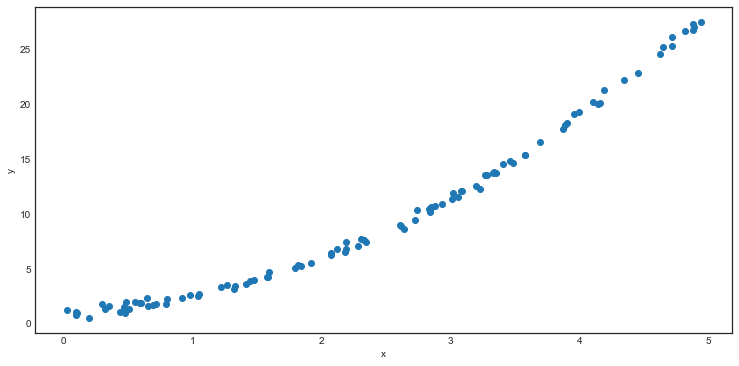

In [4]:
plt.figure(figsize=(12.5,6))
plt.scatter(x_s, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Optimize with identity map as the QoI

In [5]:
# define the QoI to simply be the identity map
id_map = lambda theta: theta

In [6]:
# set optimization parameters
EPSILON = 0.0001                   # stopping criterion for odad_min_e_ball algo
CONF_LEV = 0.95                   # 1 - beta_alpha - i.e., prob not violating
THETA_INIT = "multisample"   # initialization startgey
THETA_DIMS = 3               # dimensionality of theta
MU = 1000                          # strength of penalty
MAX_EPOCH = 100000
MIN_IMPROVMENT = 0.01
PATINCE = 1000
LR = 0.001      

In [7]:
forward_model = lambda theta: jax.vmap(model, in_axes=[None, 0])(theta, x_s)

In [8]:
# create objective function and optimizer objects
objective_obj = DifferentaibleMeritFunc(
    forward_model=forward_model, 
    mu=MU, 
    data=y,
    qoi_func=id_map
)
optimizer = GdOpt(objective=objective_obj)

mle_theta, M_alpha, S, center, radius_0 = optimizer.optimize_min_e_ball(
    sigma_2=SIGMA2,
    data=y,
    initial_theta=THETA_INIT,
    theta_dims=THETA_DIMS,
    raduis_eps=EPSILON,
    conf_level=CONF_LEV,
    max_epoch=MAX_EPOCH,
    lr=LR  
)

print("----- Center and Radius -----")
print(S)
print(center)
print(radius_0)

# perform optimization to find dirac weights
p_opt = optimizer.weight_optimization(S=S.astype(np.float64))
print("----- Dirac Weights -----")
print(p_opt)

----- Center and Radius -----
[[0.8443641  0.68920094 0.9620016 ]
 [1.3127195  0.2417546  1.0435436 ]
 [0.84484184 0.6921229  0.9615561 ]
 [1.3149512  0.2445829  1.0427178 ]]
[1.07878065 0.46693874 1.00254983]
0.32728542679297645
----- Dirac Weights -----
[9.47916070e-23 5.00000000e-01 5.00000000e-01 1.02800371e-22]


# Optimize with a 1d Projection

In [10]:
# define a projection for the QoI
proj_func = jax.jit(lambda theta: theta[0])

In [11]:
# set optimization parameters
EPSILON = 0.0001                   # stopping criterion for odad_min_e_ball algo
CONF_LEV = 0.95                   # 1 - beta_alpha - i.e., prob not violating
THETA_INIT = "multisample"   # initialization startgey
THETA_DIMS = 3               # dimensionality of theta
MU = 1000                          # strength of penalty
MAX_EPOCH = 100000
MIN_IMPROVMENT = 0.01
PATINCE = 1000
LR = 0.001      

In [12]:
# create objective function and optimizer objects
objective_obj = DifferentaibleMeritFunc(
    forward_model=forward_model, 
    mu=MU, 
    data=y,
    qoi_func=proj_func
)
optimizer = GdOpt(objective=objective_obj)

mle_theta, M_alpha, S, center, radius_0 = optimizer.optimize_min_e_ball(
    sigma_2=SIGMA2,
    data=y,
    initial_theta=THETA_INIT,
    theta_dims=THETA_DIMS,
    raduis_eps=EPSILON,
    conf_level=CONF_LEV,
    max_epoch=MAX_EPOCH,
    lr=LR,     
)

print("----- Center and Radius -----")
print(S)
print(center)
print(radius_0)

# perform optimization to find dirac weights
p_opt = optimizer.weight_optimization(S=S.astype(np.float64))
print("----- Dirac Weights -----")
print(p_opt)

----- Center and Radius -----
[1.0785822  1.3223134  0.83548933 0.8354573 ]
[1.07888538]
0.2434280514717102
----- Dirac Weights -----
[7.64660679e-10 5.00000240e-01 2.46292419e-01 2.53707342e-01]


# Optimize with $y$ value as the QoI

In [14]:
x_test = 10
y_true = model(THETA, x_test)
(x_test, y_true)

(10, DeviceArray(106., dtype=float32))

In [15]:
predict = lambda theta: model(theta, x_test)

In [16]:
# create objective function and optimizer objects
objective_obj = DifferentaibleMeritFunc(
    forward_model=forward_model, 
    mu=MU, 
    data=y,
    qoi_func=predict
)
optimizer = GdOpt(objective=objective_obj)

mle_theta, M_alpha, S, center, radius_0 = optimizer.optimize_min_e_ball(
    sigma_2=SIGMA2,
    data=y,
    initial_theta=THETA_INIT,
    theta_dims=THETA_DIMS,
    raduis_eps=EPSILON,
    conf_level=CONF_LEV,
    max_epoch=MAX_EPOCH,
    lr=LR    
)

print("----- Center and Radius -----")
print(S)
print(center)
print(radius_0)

# perform optimization to find dirac weights
p_opt = optimizer.weight_optimization(S=S.astype(np.float64))
print("----- Dirac Weights -----")
print(p_opt)

----- Center and Radius -----
[105.99948  108.66839  103.367935 108.660515]
[106.01816177]
2.650226593017578
----- Dirac Weights -----
[9.77836629e-09 2.57251231e-01 5.00009181e-01 2.42739578e-01]
